In [67]:
import os
import multiprocessing as mp
import cupy as cp

import llama
from llama.dev_utils import reload_module_recursively, refresh_task
reload_module_recursively(llama)
if "task" in locals().keys():
    task = refresh_task(task)

import llama
from llama import options as opts
from llama.api import enums
from llama.api.options_utils import print_options
import llama.io.loaders
from llama.io.loaders.enums import LoaderType
from llama import gpu_utils
from llama.estimate_center import (
    estimate_center_of_rotation,
    plot_center_of_rotation_estimate_results,
)
from llama.test_utils_2 import CITestHelper
from llama.api.types import r_type


In [12]:
ci_options = opts.CITestOptions(
    test_data_name="cSAXS_e18044_LamNI_201907",
    update_tester_results=True,
)
ci_test_helper = CITestHelper(options=ci_options)

n_gpus = cp.cuda.runtime.getDeviceCount()
gpu_list = list(range(0, n_gpus))
single_gpu_device_options = opts.DeviceOptions()
multi_gpu_device_options = opts.DeviceOptions(
    gpu=opts.GPUOptions(
        n_gpus=n_gpus,
        gpu_indices=gpu_list,
    )
)


In [6]:
parent_folder = ci_test_helper.inputs_folder
dat_file_path = os.path.join(parent_folder, "specES1", "dat-files", "tomography_scannumbers.txt")
parent_projection_folder = os.path.join(parent_folder, "analysis")

# # Load data - interactive
options = llama.io.loaders.LamniLoadOptions(
    loader_type=LoaderType.LAMNI_V1,
    selected_experiment_name="unlabeled",
    selected_sequences=[1, 2, 3, 4, 5, 6, 7, 8],
    selected_metadata_list=["512x512_b0_MLc_Niter500_recons"],
)

# Load data
lamni_data = llama.io.loaders.load_data_from_lamni_format(
    dat_file_path=dat_file_path,
    parent_projections_folder=parent_projection_folder,
    n_processes=int(mp.cpu_count() * 0.8),
    options=options,
)


User-provided loading options:
  loader_type: lamni_v1
  selected_experiment_name: unlabeled
  selected_metadata_list: ['512x512_b0_MLc_Niter500_recons']
  selected_sequences: [1, 2, 3, 4, 5, 6, 7, 8]
  ask_for_backup_files: False
2505 scans have one or more projection files.
Use these settings to bypass user-selection on next load:
  selected_experiment_name="unlabeled",
  selected_sequences=[1, 2, 3, 4, 5, 6, 7, 8],
  selected_metadata_list=[
 "512x512_b0_MLc_Niter500_recons"
],
Loading projections into list...


100%|██████████████████████████████████████████████████████████████████████████▉| 2053/2054 [02:16<00:00, 14.99it/s]


Loading complete. Duration: 137.32086324691772


In [11]:
# Convert projection dict to an array
pad_by = 256
new_shape = 2432 + pad_by, 1664 + pad_by
projection_array = llama.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
    new_shape=new_shape,
)


Projection array shape: [2688 1920]
Fixing projections dimensions...


100%|███████████████████████████████████████████████████████████████████████████| 2054/2054 [05:19<00:00,  6.43it/s]

Fixing projections dimensions...Completed


In [ ]:
ci_test_helper.save_or_compare_results(lamni_data.probe, "lamni_data_probe")
ci_test_helper.save_or_compare_results(lamni_data.scan_numbers, "lamni_data_scan_numbers")
ci_test_helper.save_or_compare_results(lamni_data.angles, "lamni_data_angles")
ci_test_helper.save_or_compare_results(projection_array[500], "projection_array_500")
ci_test_helper.save_or_compare_results(lamni_data.probe_positions[2417], "probe_positions_2417")

: 

In [ ]:
# define projection options
projection_options = opts.ProjectionOptions(
    experiment=opts.ExperimentOptions(
        laminography_angle=61.108,
        sample_thickness=7e-06,
        pixel_size=lamni_data.pixel_size,
    ),
    input_processing=opts.ProjectionTransformOptions(
        rotation=opts.RotationOptions(
            enabled=True,
            angle=72.605,
        ),
        shear=opts.ShearOptions(
            enabled=True,
            angle=-1.296,
        ),
        downsample=opts.DownsampleOptions(
            enabled=True,
            scale=2,
            use_gaussian_filter=True,
        ),
    ),
)
# Pin the projections to speed up GPU calculations
projection_array = llama.gpu_utils.pin_memory(projection_array)

complex_projections = llama.ComplexProjections(
    projections=projection_array,
    angles=lamni_data.angles,
    scan_numbers=lamni_data.scan_numbers,
    options=projection_options,
    probe_positions=list(lamni_data.probe_positions.values()),
    probe=lamni_data.probe,
    skip_pre_processing=False,
)

task = llama.LaminographyAlignmentTask(
    options=opts.AlignmentTaskOptions(),
    complex_projections=complex_projections,
)

# show results
i = 0
task.complex_projections.plot_data(
    options=opts.PlotDataOptions(index=i),
    show_plot=False,
)
task.complex_projections.probe_positions.plot_positions(index=i)


: 

In [7]:
from llama.io.load import load_task
path = os.path.join(ci_test_helper.parent_folder, "2x_downsampled_task.h5")
# task.save_task(path)
task = load_task(path)

Loading task from /net/micdata/data3/hruth/pyxalign_ci_test_data/cSAXS_e18044_LamNI_201907/2x_downsampled_task.h5 ...
'momentum' not found in saved options, using default values for 'momentum'.
ProjectionOptions → estimate_center.projection_matching.momentum

'momentum' not found in saved options, using default values for 'momentum'.
AlignmentTaskOptions → projection_matching.momentum

Loading complete


In [ ]:
del lamni_data, projection_array

In [8]:
gpu_utils.is_pinned(task.complex_projections.data)

False

- device options
     - device_type: gpu
     - gpu options
          - chunking_enabled: True
          - chunk_length: 20
          - n_gpus: 8
          - gpu_indices: [0, 1, 2, 3, 4, 5, 6, 7]
- iterations: 10
- binning: 4
- filter_position: 101
- filter_data: 0.005
- precision: 0.01
- remove_slow_variation: True
- use_end_corrections: False
- crop options
     - horizontal_range: 704
     - vertical_range: 704
     - horizontal_offset: 0
     - vertical_offset: 0
     - enabled: True
     - return_view: False
process_func not provided, defaulting to plotting angle of complex projections


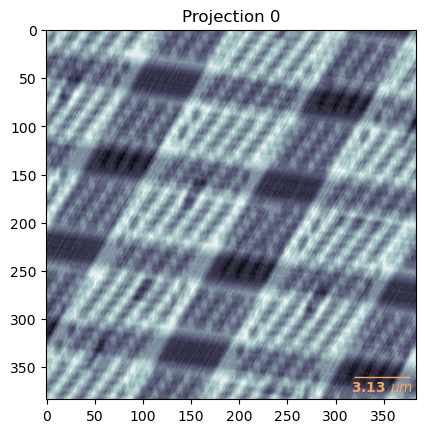

In [26]:
w = 384
crop_options = opts.CropOptions(enabled=True, horizontal_range=w, vertical_range=w)
print_options(task.options.cross_correlation)
task.complex_projections.plot_data(opts.PlotDataOptions(crop=crop_options, index=0))


In [18]:
task.complex_projections.pin_arrays()

- device options
     - device_type: gpu
     - gpu options
          - chunking_enabled: True
          - chunk_length: 20
          - n_gpus: 8
          - gpu_indices: [0, 1, 2, 3, 4, 5, 6, 7]
- iterations: 10
- binning: 4
- filter_position: 51
- filter_data: 0.005
- precision: 0.01
- remove_slow_variation: False
- use_end_corrections: True
- crop options
     - horizontal_range: 384
     - vertical_range: 384
     - horizontal_offset: 0
     - vertical_offset: 0
     - enabled: True
     - return_view: False


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


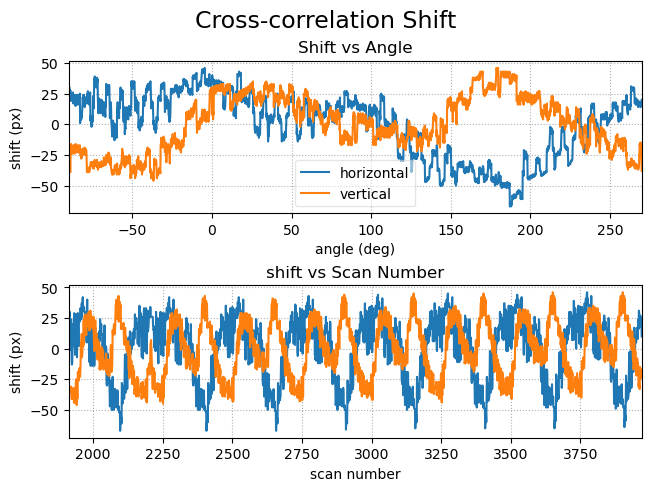

Cross-correlation shift stored in shift_manager


In [63]:
print_options(task.options.cross_correlation)

task.options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=4,
    # filter_position=51,
    filter_data=0.005,
    # precision=0.01,
    remove_slow_variation=False,
    crop=crop_options,
    device=multi_gpu_device_options,
    use_end_corrections=True,
)
task.get_cross_correlation_shift()


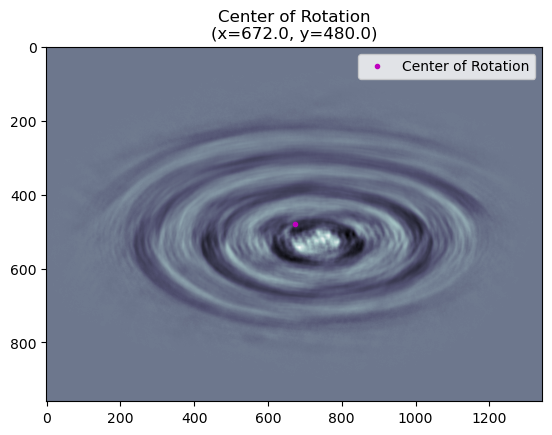

In [64]:
task.complex_projections.apply_staged_shift()
task.complex_projections.show_center_of_rotation()

### skip (cross-corr with slow variation removal)

- device options
     - device_type: gpu
     - gpu options
          - chunking_enabled: True
          - chunk_length: 20
          - n_gpus: 8
          - gpu_indices: [0, 1, 2, 3, 4, 5, 6, 7]
- iterations: 10
- binning: 4
- filter_position: 9
- filter_data: 0.005
- precision: 0.01
- remove_slow_variation: False
- use_end_corrections: False
- crop options
     - horizontal_range: 704
     - vertical_range: 704
     - horizontal_offset: 0
     - vertical_offset: 0
     - enabled: True
     - return_view: False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.85it/s]


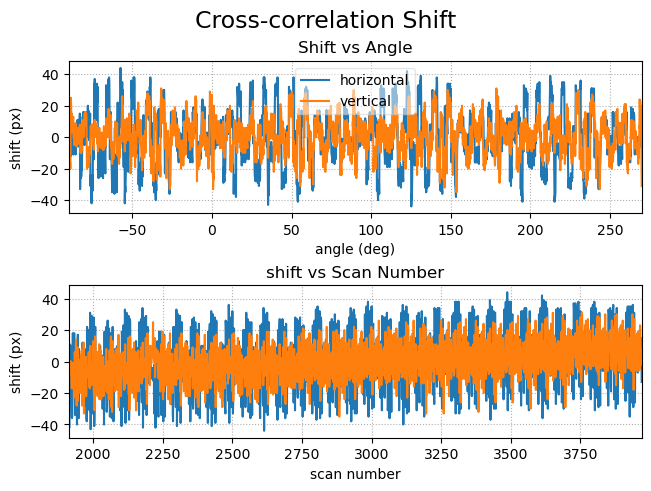

Cross-correlation shift stored in shift_manager


In [ ]:
print_options(task.options.cross_correlation)

task.options.cross_correlation = opts.CrossCorrelationOptions(
    iterations=10,
    binning=4,
    filter_position=51,
    filter_data=0.005,
    precision=0.01,
    remove_slow_variation=True,
    crop=crop_options,
    device=multi_gpu_device_options,
    use_end_corrections=False,
)
task.get_cross_correlation_shift()


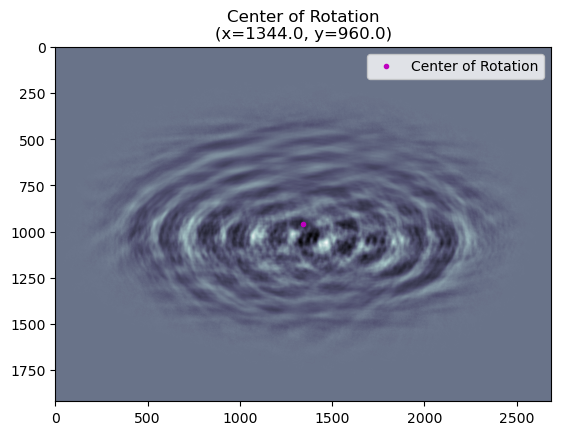

In [133]:
task.complex_projections.apply_staged_shift()
task.complex_projections.show_center_of_rotation()

In [134]:
task.complex_projections.undo_last_shift()

### <hr>

In [90]:
task.complex_projections.options.phase_unwrap = opts.PhaseUnwrapOptions(
    device=multi_gpu_device_options,
    iterations=10,
    lsq_fit_ramp_removal=False,
)
# # Pin data used in calculating phase projections
# pinned_data = gpu_utils.create_empty_pinned_array(
#     task.complex_projections.data.shape, dtype=r_type
# )
task.get_unwrapped_phase(pinned_data)

AttributeError: 'NoneType' object has no attribute 'shape'

In [74]:
task.get_unwrapped_phase(pinned_data)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
from llama.estimate_center import (
    estimate_center_of_rotation,
    plot_center_of_rotation_estimate_results,
)

task.phase_projections.options.estimate_center = opts.EstimateCenterOptions(
    horizontal_coordinate=opts.CoordinateSearchOptions(
        enabled=True,
        range=20,
        spacing=1,
    ),
)
task.phase_projections.options.estimate_center.downsample.scale = 16
task.phase_projections.options.estimate_center.downsample.use_gaussian_filter = True
task.phase_projections.options.estimate_center.projection_matching.reconstruct.astra.back_project_gpu_indices = gpu_list
task.phase_projections.options.estimate_center.projection_matching.reconstruct.astra.forward_project_gpu_indices = gpu_list
set_all_device_options(
    task.phase_projections.options.estimate_center.projection_matching, multi_gpu_device_options
)
print_options(task.phase_projections.options.estimate_center)
